## Testing Stacks

**Purpose**: We saw in Notebook `7_consolidated_ST.ipynb` that our pipeline works mostly for Ciera's faint MS2 dot video's, but we want to see how robust it is for different types of MS2 videos. So we are taking some very good example data taken from Augusto.

Augusto's Data Full Data: https://www.dropbox.com/sh/umutoxcy3ebdanj/AADdV_ns2xlkxXzxli7zImvCa?dl=0&lst=

Data Example: https://www.dropbox.com/sh/umutoxcy3ebdanj/AAAO6vajYWaSfYa81C9fHG2oa/2018-01-05/EVE_D9?dl=0&lst=&subfolder_nav_tracking=1

In [6]:
import numpy as np
import pandas as pd
import czifile
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns

from skimage.feature import blob_doh, blob_dog, blob_log
from skimage.color import rgb2gray #to turn into grayscale

from ipywidgets import interact #for interactions

#clustering
from sklearn.cluster import DBSCAN
from skimage import filters, measure, segmentation, feature, img_as_ubyte, morphology

from scipy import ndimage as ndi

In [51]:
# reading in images
# Example EVE_D9
array1 = czifile.imread("/Users/cierapink/Desktop/EVE_D9/EVE_D9-14.czi") 

# (time, channel, z-stack, y-axis, and x-axis), 0 is the dot's channel
array1 = array1.squeeze() #get rid of unwanted channels
array1.shape

(10, 2, 21, 256, 1024)

In [52]:
#preprocessing: 
zstack = array1[9, 0, :, ...] #MS2 (dots) #FIRST TIMEPOINT
IM_MAX = np.max(zstack, axis=0) #maximum projection 
image_gray = rgb2gray(IM_MAX)
image_gray

array([[ 801, 1487, 1549, ...,  817, 1461,  802],
       [ 844, 2523, 1552, ..., 1648, 1098, 2027],
       [1152, 1929,  598, ..., 1264, 3035,  819],
       ...,
       [1142, 1660, 2226, ...,  997,  915, 1071],
       [2841, 1161, 1266, ..., 1666, 1194, 1855],
       [ 797, 2255, 2011, ..., 1673, 1857,  745]], dtype=uint16)

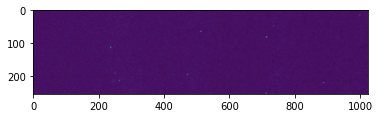

In [53]:
#original image: 
plt.imshow(IM_MAX);


## MS2 dots

In [54]:
#function to display image and create dataframe: 

def show_blobs(blobs_coords): 
    
    fig, ax = plt.subplots() #created ax just to add patches
    plt.imshow(IM_MAX)

    for idx in range(len(blobs_coords)):
        for blob in blobs_coords: 
            y, x, r = blob
            c = plt.Circle((x, y), r, color="lime", linewidth=2, fill=False)
            ax.add_patch(c)


    #make into dataframe first (no cleaning)
    x = [arr[1] for arr in blobs_coords] #note, the x and y coordinates are returned in opposite order hence the indexing
    y = [arr[0] for arr in blobs_coords]
    sd = [arr[2] for arr in blobs_coords]
    timepoint_1 = pd.DataFrame({"dots": np.arange(1, len(blobs_coords)+1), "x":x, "y":y, "sd":sd})
    
    return timepoint_1



def timepoint_df(blobs_coords, tp): 
    #make into dataframe first (no cleaning)
    x = [arr[1] for arr in blobs_coords] #note, the x and y coordinates are returned in opposite order hence the indexing
    y = [arr[0] for arr in blobs_coords]
    sd = [arr[2] for arr in blobs_coords]
    timepoint = pd.DataFrame({"dots": np.arange(1, len(blobs_coords)+1), 
                              "x":x, 
                              "y":y, 
                              "sd":sd, 
                              "timept": np.zeros(len(blobs_coords)) + tp})
    
    return timepoint

### Manul Threshold 1

,dots,x,y,sd
0,1,712.0,255.0,4.096
1,2,888.0,220.0,1.600
2,3,264.0,214.0,1.600
3,4,472.0,196.0,1.600
4,5,237.0,113.0,1.600
5,6,713.0,82.0,1.600
6,7,512.0,65.0,1.600
7,8,999.0,15.0,1.000


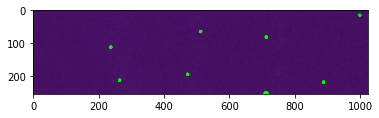

In [58]:
## Testing 
blobs_dog = blob_dog(image_gray, max_sigma=8, threshold=.04) 
show_blobs(blobs_dog)

### Set Manual Threshold from above 

In [68]:
def all_timepoints_combined(total_tp, array):
    
    df = pd.DataFrame() #initalize
    
    for i in range(total_tp): 
        zstack = array[i, 0, :, ...] #MS2 (dots) 
        IM_MAX = np.max(zstack, axis=0) #maximum projection 
        image_gray = rgb2gray(IM_MAX)
        
        blobs_dog = blob_dog(image_gray, max_sigma=8, threshold=.04)
        timepoint = timepoint_df(blobs_dog, i)
        df = df.append(timepoint).reset_index(drop=True)
    
    return df




In [62]:
array1_timepoints = all_timepoints_combined(9, array1)
array1_timepoints.head()

,dots,x,y,sd,timept
0,1,731.0,255.0,1.6,0.0
1,2,867.0,251.0,1.6,0.0
2,3,248.0,250.0,1.6,0.0
3,4,692.0,247.0,1.6,0.0
4,5,895.0,246.0,1.6,0.0


In [69]:
#sanity check
temp = array1_timepoints[["x", "y", "timept"]].groupby("timept").agg(list)

@interact(index=(0, 9))
def scatter(index=0): 
    x = temp.iloc[index,:]["x"]
    y = temp.iloc[index,:]["y"]
    plt.scatter(x, y)
    
    #formatting:
    plt.xlim([0, 1200])
    plt.xticks(np.arange(0, 1200, 200))
    plt.ylim([300, 0])
    plt.yticks(np.arange(0, 300, 100))

interactive(children=(IntSlider(value=0, description='index', max=9), Output()), _dom_classes=('widget-interac…

In [70]:
@interact(i=(0,9))
def show_images(i=5):
    zstack = array1[i, 0, :, ...] #MS2 (dots)
    IM_MAX = np.max(zstack, axis=0) #maximum projection 
    plt.imshow(IM_MAX)

interactive(children=(IntSlider(value=5, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

In [71]:
trial1 = array1_timepoints[array1_timepoints["timept"] != len(array1_timepoints)-1][["x", "y", "timept"]]  
trial1.head()

,x,y,timept
0,731.0,255.0,0.0
1,867.0,251.0,0.0
2,248.0,250.0,0.0
3,692.0,247.0,0.0
4,895.0,246.0,0.0


## Clustering -- Manual Threshold 3

In [72]:
cluster = DBSCAN(eps=40, min_samples=2) #can specify min distance to be considered neighbors,  min # of samples in neighborhood 
lab = cluster.fit_predict(trial1) #fits clustering algorithm and returns a cluster label

lab

array([0, 1, 2, 0, 1, 2, 0, 3, 1, 1, 3, 2, 2, 3, 0, 2, 1, 0, 2, 3, 1, 1,
       2, 0, 2, 1, 1, 0, 2, 3, 1, 1, 2, 2, 3, 3, 1, 3, 1, 2, 4, 3, 2, 4,
       1, 2, 1, 3, 1, 1, 4, 1, 3, 2, 1, 1, 3, 2, 2, 1, 3, 4, 4, 2, 3, 4,
       3, 1, 1, 0, 0, 2, 1, 0, 2, 3, 0, 1, 1, 3, 2, 2, 3, 0, 1, 2, 0, 3,
       1, 2, 0, 2, 1, 2, 1, 0, 2, 3, 1, 2, 2, 3, 3, 1, 3, 2, 4, 3, 2, 4,
       1, 2, 3, 1, 1, 1, 1, 4, 2, 1, 1, 3, 2, 2, 1, 3, 4, 4, 1, 2, 2, 1,
       4, 3, 1, 1, 4, 0, 3, 2, 0, 1, 2, 0, 3, 1, 1, 3, 2, 2, 0, 3, 2, 1,
       2, 0, 3, 1, 1, 2, 2, 0, 0, 2, 1, 2, 1, 2, 2, 3, 3, 1, 3, 2, 4, 3,
       2, 2, 1, 2, 1, 3, 1, 1, 4, 1, 4, 2, 1, 1, 4, 3, 2, 2, 3, 1, 4, 4,
       4, 2, 1, 2, 1, 1, 3, 4, 3, 1, 0, 3, 3, 2, 1, 0, 2, 0, 1, 1, 3, 2,
       3, 0, 2, 2, 1, 0, 1, 3, 1, 2, 2, 0, 2, 0, 1, 2, 1, 2, 2, 2, 3, 3,
       1, 1, 2, 3, 2, 4, 3, 2, 2, 1, 2, 1, 4, 1, 4, 1, 1, 4, 2, 1, 1, 4,
       3, 2, 2, 3, 1, 4, 4, 4, 1, 2, 2, 1, 1, 4, 3, 0, 3, 3, 2, 0, 1, 2,
       0, 1, 3, 1, 3, 2, 0, 1, 2, 1, 1, 3, 1, 2, 0,

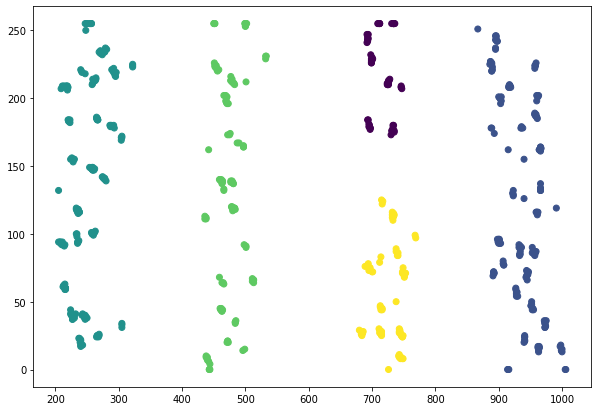

In [73]:
plt.figure(figsize=(10, 7))  
plt.scatter(trial1["x"], trial1["y"], c=cluster.labels_);

In [74]:
trial1["DBSCAN_labels"] = lab
trial1.head()

,x,y,timept,DBSCAN_labels
0,731.0,255.0,0.0,0
1,867.0,251.0,0.0,1
2,248.0,250.0,0.0,2
3,692.0,247.0,0.0,0
4,895.0,246.0,0.0,1


In [75]:
#can check (notice that none of the aggregated points are from the same timepoint--so no overlaps)
# if they do, may want to play with thresholds more
trial1[["DBSCAN_labels", "timept"]].groupby("DBSCAN_labels").agg(list).head(5)

,timept
DBSCAN_labels,
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ..."


## Nucleus Centers - Manual Threshold 4

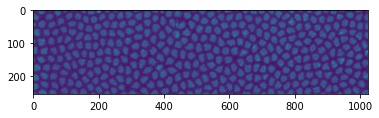

In [76]:
#using the same array we read in: 
zstack = array1[1, 1, :, ...] #(timepoint, channel, etc.) this one is timepoint 1
zstack.shape

zstack_MAX= np.max(zstack, axis=0)
plt.imshow(zstack_MAX)
plt.show()

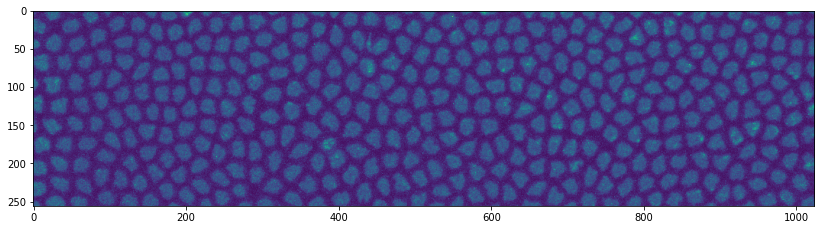

In [77]:
# Convert to 8bit
zstack_MAX_8bit = img_as_ubyte(zstack_MAX)
plt.figure(figsize=(14, 16))
plt.imshow(zstack_MAX_8bit);

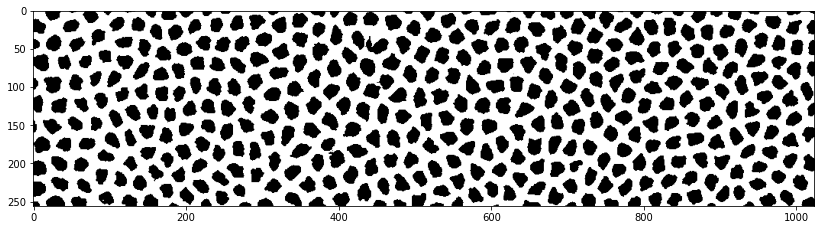

In [78]:
#### PART 1: Find centers with a conservative threshold
### First perform the conservative threshold on every point in the Z axis with the Otsu threshold
zstack_MAX_8bit_GausFilt = ndi.filters.gaussian_filter(zstack_MAX_8bit, 1) # blur image and remove noise

otsuthresh = filters.threshold_otsu(zstack_MAX_8bit_GausFilt) # grey scale 
zstack_MAX_8bit_GausFilt_localtheshold = zstack_MAX_8bit_GausFilt > otsuthresh

plt.figure(figsize=(14, 16))
plt.imshow(zstack_MAX_8bit_GausFilt_localtheshold, cmap = "Greys");

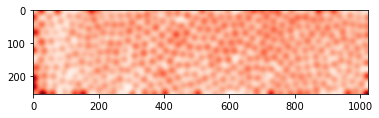

In [107]:
#### Then Call centers 
### Distance transform
distancetransform_combined_final = ndi.distance_transform_edt(zstack_MAX_8bit_GausFilt_localtheshold)

#### smoothen the distance transform
distancetransform_combined_final_gaus = ndi.filters.gaussian_filter(distancetransform_combined_final, 10)

plt.figure()
plt.imshow(distancetransform_combined_final_gaus, cmap = "Reds");

In [104]:
#### Retrieve the local maxima from the distance transform
## Gives a true false for every pixel if it is the max local peak?
Local_max = feature.peak_local_max(distancetransform_combined_final_gaus, indices = False, min_distance = 40)
Local_max_bigger = ndi.filters.maximum_filter(Local_max, size=20)

#makes a mask so that I can visualize on top of the original image
Local_max_mask = np.ma.array(Local_max_bigger, mask=Local_max_bigger==0)

#Add that mask back into the watershed image
CenterPointArrays = Local_max_bigger

In [105]:
#### PART 2: Now make a mask with a permissive threshold that goes all the way to the edges of the nuclei.
image_GausFilt = ndi.filters.gaussian_filter(zstack_MAX_8bit, 20)
localthresh = filters.threshold_local(image_GausFilt, 41)
image_GausFilt_localtheshold = image_GausFilt > localthresh
image_GausFilt_localtheshold_dilate = morphology.binary_dilation(image_GausFilt_localtheshold)
EdgeMask = image_GausFilt_localtheshold_dilate

#### Part 3: watershed
## Seperate objects
CenterPointArrays_items, num = ndi.label(CenterPointArrays)

## Watershed
watershed_image = morphology.watershed(~zstack_MAX_8bit_GausFilt, CenterPointArrays_items, mask = EdgeMask)

#### Part 4: Clear borders
Watershed_ClearBorders = segmentation.clear_border(watershed_image)

### Itemize
labeled_array_segmentation, num_features_seg = ndi.label(Local_max_mask)

## Don't understand how the CenterPointArrays is actually specifying points,
## I need to figure this out so I can assign nuclei identities

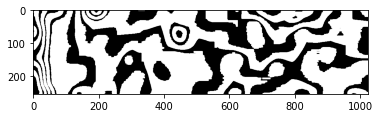

In [106]:
## EdgeMask Gaussian septerated. 
## Why not just do this instead of watershed?
EdgeMask_gauss = ndi.filters.gaussian_filter(EdgeMask, .5)
plt.figure()
plt.imshow(EdgeMask_gauss, "Greys");

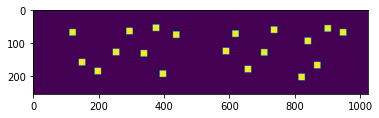

In [86]:
plt.imshow(Local_max_bigger); #located the centers

In [87]:
#get center coordinates (each center is equal to 1), 
#and the coordinates are the indices for row and column of the 1 value in matrix

y_len = len(Local_max_bigger)
x_len = len(Local_max_bigger[1])
centersX = []
centersY = []
for j in range(y_len): 
    for i in range(x_len):
        if Local_max_bigger[j][i] > 0: 
            centersX.append(i)
            centersY.append(j)
        

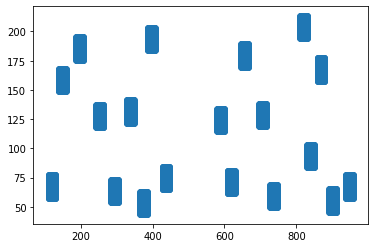

In [88]:
centers = pd.DataFrame({"x":centersX, 
                        "y": centersY})
# plt.imshow(EdgeMask_gauss, "Greys");
plt.scatter(centers["x"], centers["y"]);
# plt.ylim([950, 0]);
# plt.axis((0, 310, 200, 0)); #notice that centers are all squares

In [89]:
cluster_ft = DBSCAN(eps=1, min_samples=4) 
labels = cluster_ft.fit_predict(centers)
labels

array([ 0,  0,  0, ..., 18, 18, 18])

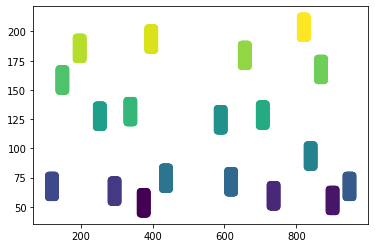

In [90]:
plt.figure()
plt.scatter(centers["x"], centers["y"], c=cluster_ft.labels_);
#it's hard to tell that they are different, but the colors 
#are different shades (otherwise it would look like above)
#indicating different clusters = 147 total unique ones 

In [91]:
np.unique(labels) #theres 140 centers here in this stack

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [92]:
centers["center_labels"] = labels

In [93]:
centers.head()

,x,y,center_labels
0,366,44,0
1,367,44,0
2,368,44,0
3,369,44,0
4,370,44,0


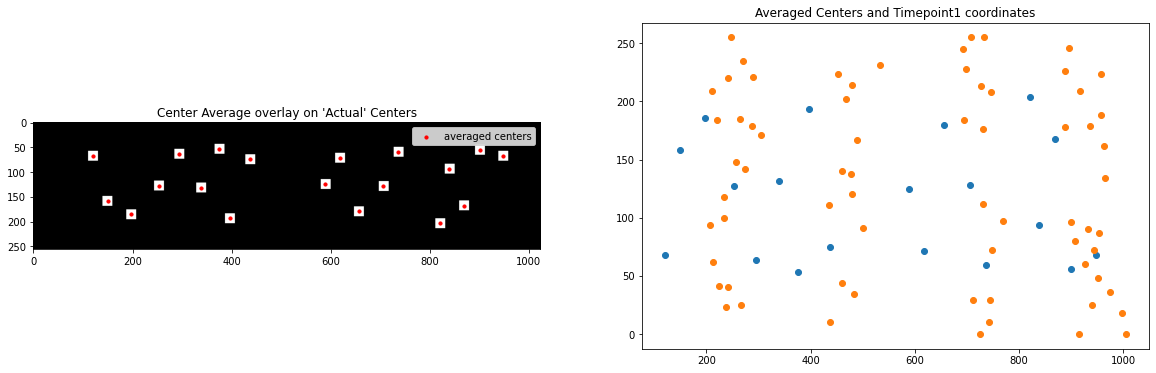

In [94]:
timepoint1 = trial1[trial1["timept"] == 1] #test with 1 timepoint of array1

avg_cent = centers.groupby("center_labels").mean() #average of the centers (so that it's only one coordinate)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].imshow(Local_max_bigger, cmap="gray", label="actual") #actual centers
ax[0].scatter(avg_cent.x, avg_cent.y, s=10, color='red', label="averaged centers"); #averaged centers coords
ax[0].set_title("Center Average overlay on 'Actual' Centers")
ax[0].legend()

ax[1].scatter(avg_cent.x, avg_cent.y);
ax[1].scatter(timepoint1["x"], timepoint1["y"]);
# ax[1].set_ylim(1000, 0);
ax[1].set_title("Averaged Centers and Timepoint1 coordinates");

In [95]:
#let's loop through the timepoint 1 coordinates and compare it with all the avg_cent point coordinates, 
#if it's close then i'll associate that MS2 point to that center (and that MS2 dot will be grouped the same label as the centers)
#there's probably a clustering algorithm that optimizes this ... (kmeans on MS2 dots with fixed centers?)

#we're going to be using euclidean distance
def euclidean_dist(x1, y1, x2, y2): 
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

dist = float('inf') #temp
closest_center_label = -1 #temp
#in the same order as timepoint1 inputs
label_list = []

for i in range(len(timepoint1)): 
    x1 = timepoint1.iloc[i]["x"]
    y1 = timepoint1.iloc[i]["y"]
    
    for j in range(len(avg_cent)): 
        x2 = avg_cent.iloc[j]["x"]
        y2 = avg_cent.iloc[j]["y"]
        
        new_dist = euclidean_dist(x1, y1, x2, y2)
        if new_dist < dist: 
            dist = new_dist
            closest_center_label = avg_cent.index[j]
            
    #add/record in dictionary after searching through all centers
    label_list.append(closest_center_label)
    #reset distance 
    dist = float('inf')

In [96]:
timepoint1["closest_center_labels"] = label_list

/Users/cierapink/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [97]:
timepoint1.head()

,x,y,timept,DBSCAN_labels,closest_center_labels
69,734.0,255.0,1.0,0,18
70,709.0,255.0,1.0,0,15
71,247.0,255.0,1.0,2,16
72,896.0,246.0,1.0,1,14
73,693.0,245.0,1.0,0,15


IndexError: single positional indexer is out-of-bounds

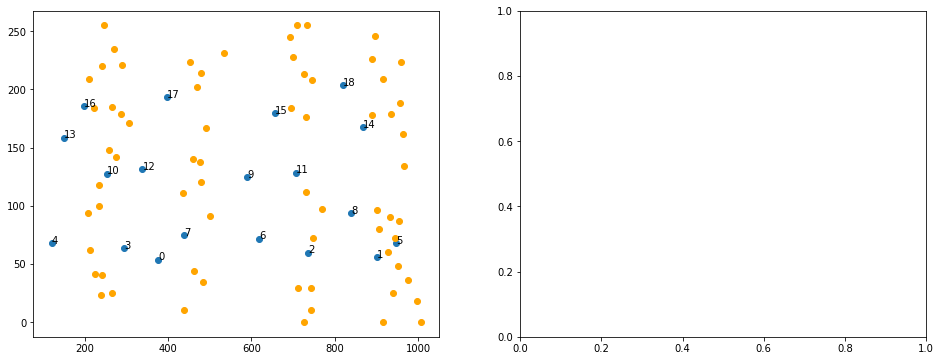

In [103]:

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(avg_cent.x, avg_cent.y);
ax[0].scatter(timepoint1["x"], timepoint1["y"], color="orange");
for i, txt in enumerate(np.arange(23)): #counter and text ------ notice text/counter need to be same size as label
    ax[0].annotate(txt, (avg_cent.iloc[i]["x"], avg_cent.iloc[i]["y"]))


ax[1].scatter(timepoint1["x"], timepoint1["y"], color="orange");
for i, txt in enumerate(timepoint1["closest_center_labels"]): #counter and text
    ax[1].annotate(txt, (timepoint1.iloc[i]["x"], timepoint1.iloc[i]["y"]))




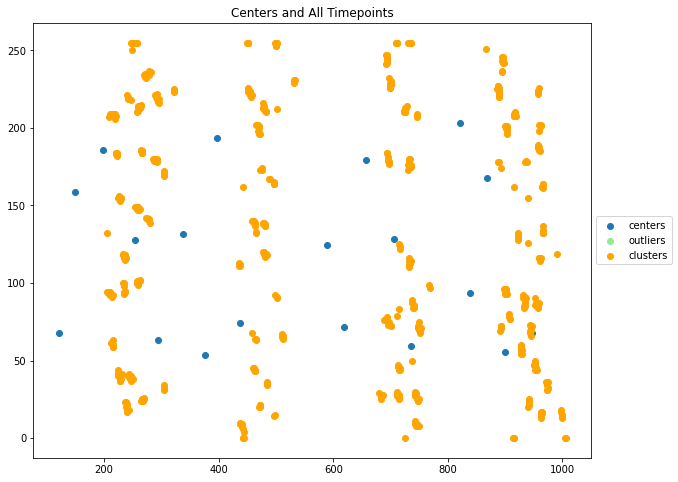

In [99]:
plt.figure(figsize=(10, 8))

plt.scatter(avg_cent.x, avg_cent.y, label="centers");
plt.scatter(trial1[trial1["DBSCAN_labels"] == -1]["x"], trial1[trial1["DBSCAN_labels"] == -1]["y"], color="lightgreen", label="outliers");
plt.scatter(trial1[trial1["DBSCAN_labels"] != -1]["x"], trial1[trial1["DBSCAN_labels"] != -1]["y"], color="orange", label="clusters");
plt.title("Centers and All Timepoints");
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

#supposed outlier points are in lightgreen
#all other MS2 dots are in orange
#center of nuclei are in blue

#but it does seem like there are some light green points near centers 
#not sure if this means that some of our clusterings for -1 are not actually noise

In [100]:
#function
def associate_centers(df):
    
    dist = float('inf') #temp
    closest_center_label = -1 #temp
    #in the same order as trial1 inputs
    label_list = []

    for i in range(len(df)): 
        x1 = df.iloc[i]["x"]
        y1 = df.iloc[i]["y"]

        for j in range(len(avg_cent)): 
            x2 = avg_cent.iloc[j]["x"]
            y2 = avg_cent.iloc[j]["y"]

            new_dist = euclidean_dist(x1, y1, x2, y2)
            if new_dist < dist: 
                dist = new_dist
                closest_center_label = avg_cent.index[j]

        #add/record in dictionary after searching through all centers
        label_list.append(closest_center_label)
        #reset distance 
        dist = float('inf')
        
    return label_list

In [101]:
label_list = associate_centers(trial1)
trial1["closest_center_labels"] = label_list

IndexError: single positional indexer is out-of-bounds

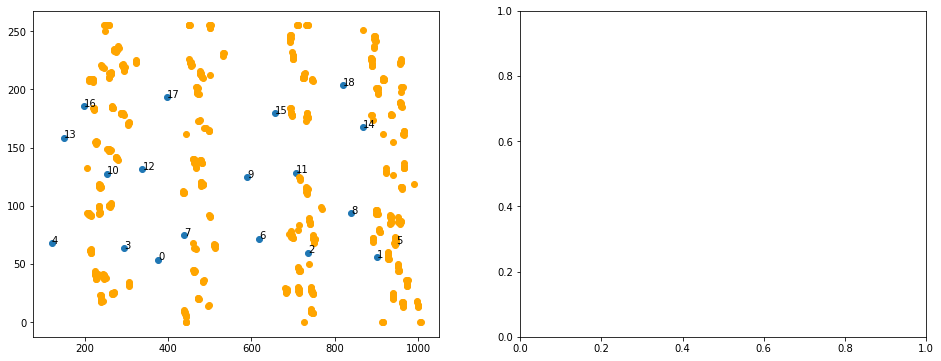

In [102]:
non_outliers = trial1[trial1["DBSCAN_labels"] != -1]
outliers = trial1[trial1["DBSCAN_labels"] == -1]

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(avg_cent.x, avg_cent.y);
ax[0].scatter(non_outliers["x"], non_outliers["y"], color="orange");
ax[0].scatter(outliers["x"], outliers["y"], color="lightgreen");
for i, txt in enumerate(np.arange(23)): #counter and text
    ax[0].annotate(txt, (avg_cent.iloc[i]["x"], avg_cent.iloc[i]["y"]))

    
ax[1].scatter(non_outliers["x"], non_outliers["y"], color="orange");
seen = []
for i, txt in enumerate(non_outliers["closest_center_labels"]): #counter and text
    if txt not in seen:
        ax[1].annotate(txt, (non_outliers.iloc[i]["x"], non_outliers.iloc[i]["y"]))
        seen.append(txt)

ax[1].scatter(outliers["x"], outliers["y"], color="lightgreen");
seen2 = []
for i, txt in enumerate(outliers["closest_center_labels"]): #counter and text
    if txt not in seen2:
        ax[1].annotate(txt, (outliers.iloc[i]["x"], outliers.iloc[i]["y"]))
        seen2.append(txt)
        
ax[1].set_title("All Timepoints and Center Labels");

In [82]:
trial1

,x,y,timept,DBSCAN_labels,closest_center_labels
0,452.0,247.0,0.0,-1,21
1,367.0,200.0,0.0,0,20
2,540.0,188.0,0.0,1,18
3,515.0,169.0,0.0,1,18
4,748.0,149.0,0.0,-1,16
5,128.0,138.0,0.0,2,10
6,527.0,87.0,0.0,3,8
7,0.0,74.0,0.0,4,12
8,738.0,61.0,0.0,5,4
9,913.0,18.0,0.0,6,7
